## Dynamic Heterogeneous Market with Sudden Changes in the Equillibrium
The heterogeneously populated market sessions are meant to simulate PRDE performance in a real world trading exchange, including the dynamic nature of the price equillibrium. Therefore in this notebook I run multiple market sessions populated symetrically with multiple types of traders for realism (like https://arxiv.org/pdf/2208.02901.pdf), including PRDE (30B/30S, just like https://papers.ssrn.com/sol3/papers.cfm?abstract_id=4153519, the original study on PRDE performance). The sessions implement a Poisson distribution order schedule ("timemode") like a real market, fixed spacing in the price distribution ("stepmode") for reduced randomness and increased reproducibility. Each market session lasts 5 min, but could be changed to last for example the same time as a trading day at the London Stock Exchange (8h 30min). 
The PRDE traders have varying k and F parameter values. Each combination is tested 10 times. The k ranges from 4 to 1024 (https://link.springer.com/chapter/10.1007/978-3-030-37838-7_3 found the best perfomance at k = 400) and the F lies between 0 and 2.
Additionally, the experiment is conducted in a market with suddenly changing supply and demand curves.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import csv
import math
import random

import scipy as sp
from scipy import stats
import seaborn as sns 
import matplotlib.pyplot as plt 
import statsmodels.api as sm
import pandas as pd

import BSE
import helpers


def offset_t(t):
    return int(round(t/10,0))

def dynamic_heterogeneous_session_sud(k, F, trial_id_str, csv_str):
    # First, configure the trader specifications
    sellers_spec = [('PRDE', 5, {'k': k, 's_min': -1.0, 's_max': +1.0, 'F': F}), ('ZIC', 5), ('ZIP', 5), ('GVWY', 5), ('SHVR', 5) , ('SNPR', 5)]
    buyers_spec = sellers_spec
    traders_spec = {'sellers':sellers_spec, 'buyers':buyers_spec}

    # Next, confiure the supply and demand (and plot it)
    range1 = (100, 200, offset_t)
    range2 = (300, 400)
    range3 = range1

    # Next, configure order schedules
    start_time = 0
    change1_time = 60 * 2
    change2_time = 60 * 3
    end_time = 60 * 5
    supply_schedule = [{'from': start_time, 'to': change1_time, 'ranges': [range1], 'stepmode': 'fixed'},
                   {'from': change1_time, 'to': change2_time, 'ranges': [range2], 'stepmode': 'fixed'},
                   {'from': change2_time, 'to': end_time, 'ranges': [range1], 'stepmode': 'fixed'}]
    demand_schedule = supply_schedule


    order_interval = 5
    order_sched = {'sup': supply_schedule, 'dem': demand_schedule,
               'interval': order_interval, 'timemode': 'drip-poisson'}

    trial_id = trial_id_str
    tdump = open(csv_str,'w')
    dump_all = False
    verbose = False

    # Now, run the market session
    BSE.market_session(trial_id, start_time, end_time, traders_spec, order_sched, tdump, dump_all, verbose)

    tdump.close()


    #powers of 2 from 4 to 1024 or however much it would be
k_range = np.logspace(1, 10, num=10, base=2)
k_range = k_range[1:10]
k_range = k_range.astype(int)
#0 to 2 intervals of 0.2
F_range = np.linspace(0.0, 2.0, 10)


def loop_kF(n, m, trial_id_str, csv_str):
    i = 4
    for i in n:
        for j in m:
            dynamic_heterogeneous_session_sud(i, j, trial_id_str + '_' + str(i) + '_' + str(j)[0:3], csv_str + '_' + str(i) + '_' + str(j)[0:3] + '.csv')
        

   

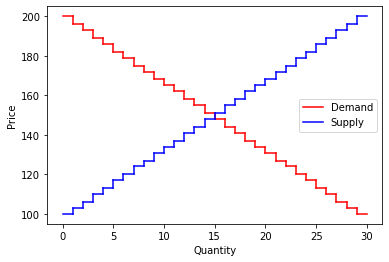

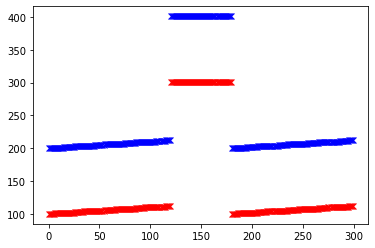

In [2]:
helpers.plot_sup_dem(30, [(100, 200, offset_t)], 30,[(100, 200, offset_t)], 'fixed')
def offset_filler(t):
    return 1
helpers.plot_offset_and_sd([(100, 200, offset_t), (300, 400), (100, 200, offset_t)], [offset_t, offset_filler, offset_t], [2*60, 1*60, 2*60], 5*60)

In [2]:
random.seed(2)
i = 0
while i < 10:
    loop_kF(k_range, F_range, 'dhets_' + str(i), 'dhets_avg_bal_' + str(i))
    i = i+1
